In [1]:
library(ISLR)

# Subset Selection Methods

## Best Subset Selection

In [3]:
library(leaps)
Hitters=na.omit(Hitters)
regfit.full=regsubsets(Salary~.,data=Hitters,nvmax=19)
summary(regfit.full)

Subset selection object
Call: regsubsets.formula(Salary ~ ., data = Hitters, nvmax = 19)
19 Variables  (and intercept)
           Forced in Forced out
AtBat          FALSE      FALSE
Hits           FALSE      FALSE
HmRun          FALSE      FALSE
Runs           FALSE      FALSE
RBI            FALSE      FALSE
Walks          FALSE      FALSE
Years          FALSE      FALSE
CAtBat         FALSE      FALSE
CHits          FALSE      FALSE
CHmRun         FALSE      FALSE
CRuns          FALSE      FALSE
CRBI           FALSE      FALSE
CWalks         FALSE      FALSE
LeagueN        FALSE      FALSE
DivisionW      FALSE      FALSE
PutOuts        FALSE      FALSE
Assists        FALSE      FALSE
Errors         FALSE      FALSE
NewLeagueN     FALSE      FALSE
1 subsets of each size up to 19
Selection Algorithm: exhaustive
          AtBat Hits HmRun Runs RBI Walks Years CAtBat CHits CHmRun CRuns CRBI
1  ( 1 )  " "   " "  " "   " "  " " " "   " "   " "    " "   " "    " "   "*" 
2  ( 1 )  " "   "*"

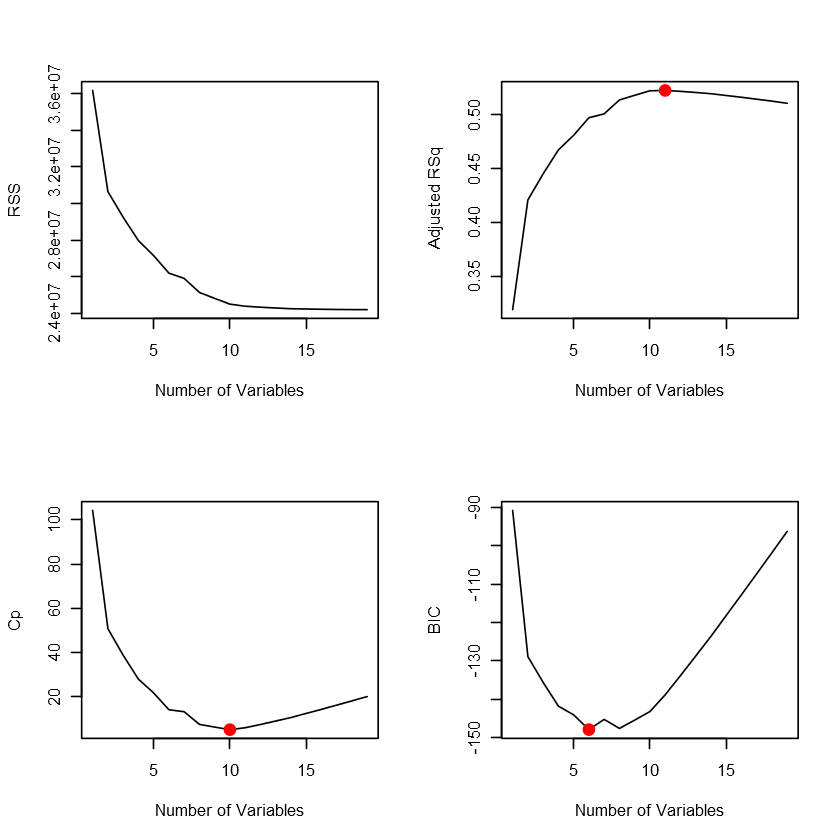

In [6]:
reg.summary=summary(regfit.full)

par(mfrow=c(2,2))
plot(reg.summary$rss,xlab="Number of Variables",ylab="RSS",type="l")

plot(reg.summary$adjr2,xlab="Number of Variables",ylab="Adjusted RSq",type="l")
idx <- which.max(reg.summary$adjr2)
points(idx,reg.summary$adjr2[idx], col="red",cex=2,pch=20)

plot(reg.summary$cp,xlab="Number of Variables",ylab="Cp",type='l')
idx <- which.min(reg.summary$cp)
points(idx,reg.summary$cp[idx],col="red",cex=2,pch=20)

plot(reg.summary$bic,xlab="Number of Variables",ylab="BIC",type='l')
idx <- which.min(reg.summary$bic)
points(idx,reg.summary$bic[idx],col="red",cex=2,pch=20)

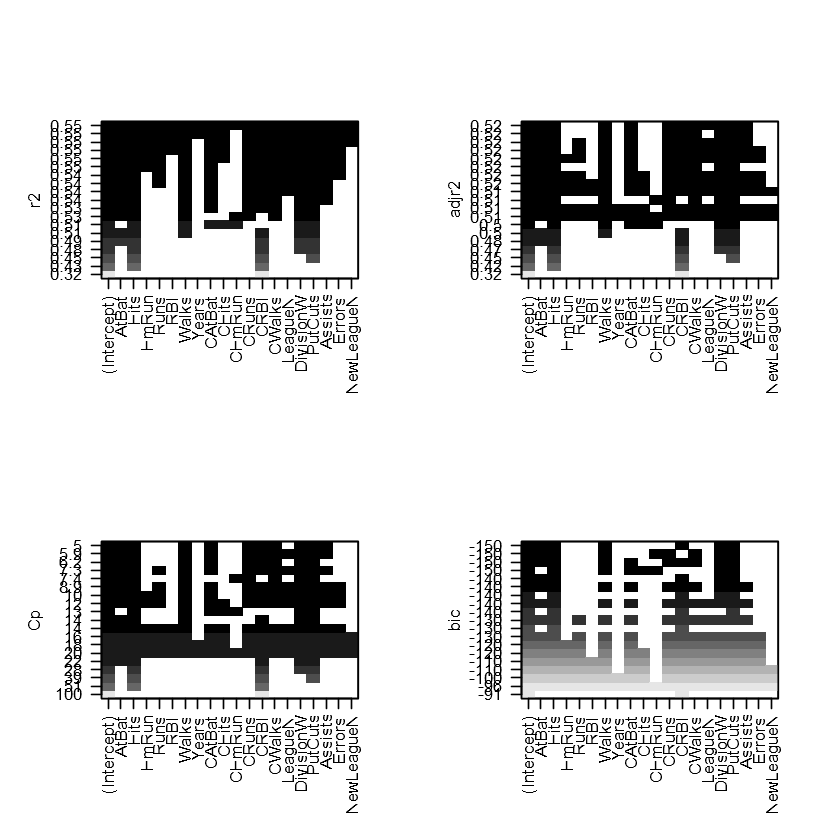

In [20]:
par(mfrow=c(2,2))
plot(regfit.full,scale="r2")
plot(regfit.full,scale="adjr2")
plot(regfit.full,scale="Cp")
plot(regfit.full,scale="bic")
# Find more with ?plot.regsubsets

## Forward and Backward Stepwise Selection

In [14]:
regfit.fwd=regsubsets(Salary~.,data=Hitters,nvmax=19,method="forward")
#summary(regfit.fwd)
regfit.bwd=regsubsets(Salary~.,data=Hitters,nvmax=19,method="backward")
#summary(regfit.bwd)

## Choosing Among Models

In [16]:
# The best model are not necessarily the same
coef(regfit.full,7)
coef(regfit.fwd,7)
coef(regfit.bwd,7)

(Intercept)         Hits        Walks       CAtBat        CHits       CHmRun 
  79.4509472    1.2833513    3.2274264   -0.3752350    1.4957073    1.4420538 
   DivisionW      PutOuts 
-129.9866432    0.2366813

(Intercept)        AtBat         Hits        Walks         CRBI       CWalks 
 109.7873062   -1.9588851    7.4498772    4.9131401    0.8537622   -0.3053070 
   DivisionW      PutOuts 
-127.1223928    0.2533404

(Intercept)        AtBat         Hits        Walks        CRuns       CWalks 
 105.6487488   -1.9762838    6.7574914    6.0558691    1.1293095   -0.7163346 
   DivisionW      PutOuts 
-116.1692169    0.3028847

In [12]:
set.seed(1)

# Prepare train and test for 19 models
train=sample(c(TRUE,FALSE), nrow(Hitters),rep=TRUE)
test=(!train)
regfit.best=regsubsets(Salary~.,data=Hitters[train,],nvmax=19)
test.mat=model.matrix(Salary~.,data=Hitters[test,])

# Compute the test MSE for each of the 19 models
val.errors=rep(NA,19)
for(i in 1:19){
    coefi=coef(regfit.best,id=i)
    pred=test.mat[,names(coefi)]%*%coefi
    val.errors[i]=mean((Hitters$Salary[test]-pred)^2)
}
val.errors

# The best model is the one which minimizes val.errors
coef(regfit.best,which.min(val.errors))

[1] 220968.0 169157.1 178518.2 163426.1 168418.1 171270.6 162377.1 157909.3
 [9] 154055.7 148162.1 151156.4 151742.5 152214.5 157358.7 158541.4 158743.3
[17] 159972.7 159859.8 160105.6

(Intercept)       AtBat        Hits       Walks      CAtBat       CHits 
-80.2751499  -1.4683816   7.1625314   3.6430345  -0.1855698   1.1053238 
     CHmRun      CWalks     LeagueN   DivisionW     PutOuts 
  1.3844863  -0.7483170  84.5576103 -53.0289658   0.2381662

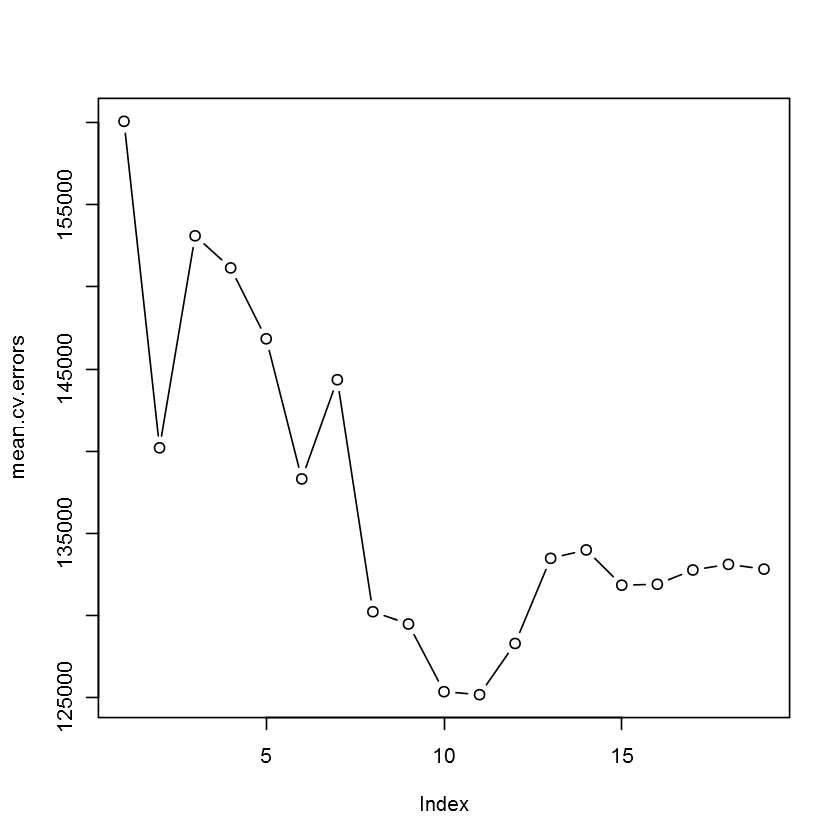

In [13]:
predict.regsubsets=function(object,newdata,id,...){
    form=as.formula(object$call[[2]])
    mat=model.matrix(form,newdata)
    coefi=coef(object,id=id)
    xvars=names(coefi)
    mat[,xvars]%*%coefi
}

k=10
set.seed(1)
folds=sample(1:k,nrow(Hitters),replace=TRUE)
cv.errors=matrix(NA,k,19, dimnames=list(NULL, paste(1:19)))
for(j in 1:k){
    best.fit=regsubsets(Salary~.,data=Hitters[folds!=j,],nvmax=19)
    for(i in 1:19){
        pred=predict(best.fit,Hitters[folds==j,],id=i)
        cv.errors[j,i]=mean( (Hitters$Salary[folds==j]-pred)^2)
    }
}
mean.cv.errors=apply(cv.errors,2,mean)
plot(mean.cv.errors,type='b')

# The best model on the plot is the 11th one. Here is how you select it
#reg.best=regsubsets(Salary~.,data=Hitters, nvmax=19)
#coef(reg.best,11)

# Ridge Regression and the Lasso

In [14]:
y=Hitters$Salary
library(glmnet)
x=model.matrix(Salary~.,Hitters)[,-1]
# The model.matrix() function is particularly useful for creating x; not only 
# does it produce a matrix corresponding to the 19 predictors but it also
# automatically transforms any qualitative variables into dummy variables.
# The latter property is important because glmnet() can only take numerical, quantitative inputs.

## Ridge Regression

In [15]:
grid=10^seq(10,-2,length=100)
ridge.mod=glmnet(x[train,],y[train],alpha=0,lambda=grid, thresh=1e-12)
dim(coef(ridge.mod))

# By default, glmnet() standardizes standardize=FALSE
# alpha = 0 is ridge, alpha = 1 is lasso

[1]  20 100

In [16]:
# lambda
ridge.mod$lambda[50]

# coefficient estimates (small because of the large lambda)
coef(ridge.mod)[,50]

# l2 norm
sqrt(sum(coef(ridge.mod)[-1,50]^2))

# We can obtain the ridge regression coefficients for a new value of lambda=50
predict(ridge.mod,s=50,type="coefficients")[1:20,]

[1] 11497.57

(Intercept)         AtBat          Hits         HmRun          Runs 
 3.890398e+02  4.121452e-02  1.583015e-01  5.433483e-01  2.495019e-01 
          RBI         Walks         Years        CAtBat         CHits 
 2.584526e-01  2.136316e-01  7.642143e-01  2.407786e-03  9.580063e-03 
       CHmRun         CRuns          CRBI        CWalks       LeagueN 
 5.325010e-02  1.819432e-02  1.675482e-02  1.584066e-02  2.472043e+00 
    DivisionW       PutOuts       Assists        Errors    NewLeagueN 
-4.757391e+00  1.295687e-02  5.336191e-04  5.363510e-02  1.858240e+00

[1] 5.76926

(Intercept)         AtBat          Hits         HmRun          Runs 
-144.98833460   -0.02348147    2.81550046   -0.53800406    1.60527796 
          RBI         Walks         Years        CAtBat         CHits 
   1.31246086    0.65564155   -0.03223843    0.01718683    0.15262640 
       CHmRun         CRuns          CRBI        CWalks       LeagueN 
   0.01599720    0.16431321    0.12713463   -0.25391129  112.45066867 
    DivisionW       PutOuts       Assists        Errors    NewLeagueN 
 -59.04328125    0.18302923   -0.26596078   -2.03791256  -25.28238878

In [17]:
# Split in train and test
set.seed(1)
train=sample(1:nrow(x), nrow(x)/2)
test=(-train)
y.test=y[test]
# If x is multiple predictor use
#xmat <- model.matrix(y ~ x + I(x^2), data)[, -1]


# Fit the model
ridge.mod=glmnet(x[train,],y[train],alpha=0,lambda=grid, thresh=1e-12)
# Compute the test MSE with lambda=4
ridge.pred=predict(ridge.mod,s=4,newx=x[test,])
mean((ridge.pred-y.test)^2)

# Fit a model with just an intercept
mean((mean(y[train])-y.test)^2)

# Least square is ridge with lambda = 0 but preder using lm() to benefit 
# and less approximations issues.
ridge.pred=predict(ridge.mod,s=0,newx=x[test,],exact=T)
mean((ridge.pred-y.test)^2) # Pretty bad result!

[1] 101036.8

[1] 193253.1

[1] 114783.1

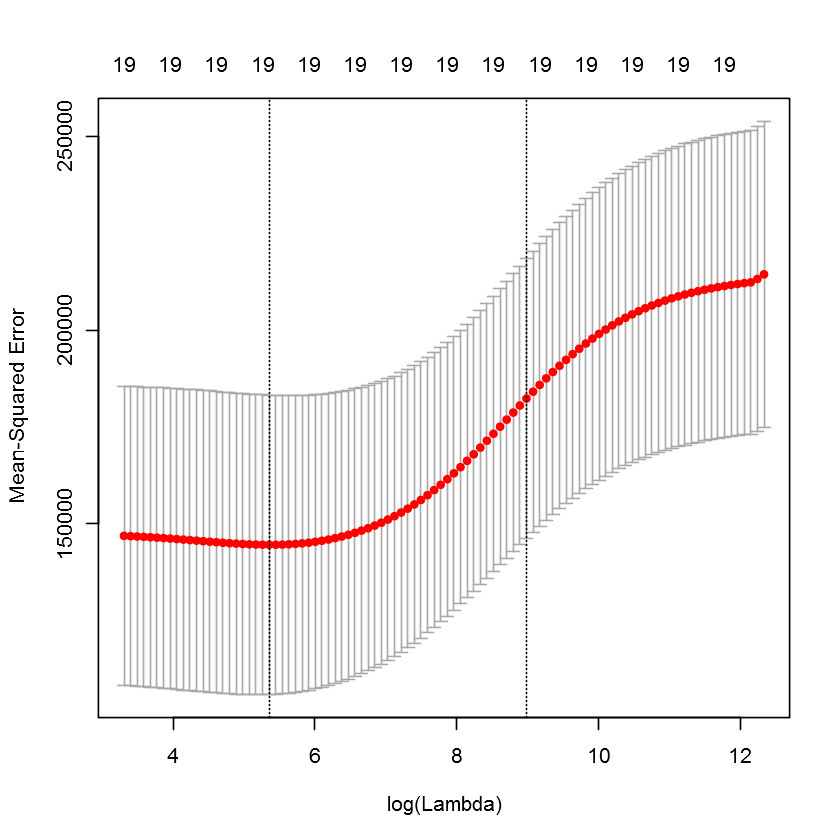

In [18]:
# Choose lambda with CV
set.seed(1)
cv.out=cv.glmnet(x[train,],y[train],alpha=0)
plot(cv.out)
bestlam=cv.out$lambda.min

In [19]:
# Compute test MSE with best lambda
ridge.pred=predict(ridge.mod,s=bestlam,newx=x[test,])
mean((ridge.pred-y.test)^2)

# Examin ethe coefficient estimates
out=glmnet(x,y,alpha=0)
predict(out,type="coefficients",s=bestlam)[1:20,]

[1] 96015.51

(Intercept)        AtBat         Hits        HmRun         Runs          RBI 
  9.88487157   0.03143991   1.00882875   0.13927624   1.11320781   0.87318990 
       Walks        Years       CAtBat        CHits       CHmRun        CRuns 
  1.80410229   0.13074381   0.01113978   0.06489843   0.45158546   0.12900049 
        CRBI       CWalks      LeagueN    DivisionW      PutOuts      Assists 
  0.13737712   0.02908572  27.18227535 -91.63411299   0.19149252   0.04254536 
      Errors   NewLeagueN 
 -1.81244470   7.21208390

## The Lasso

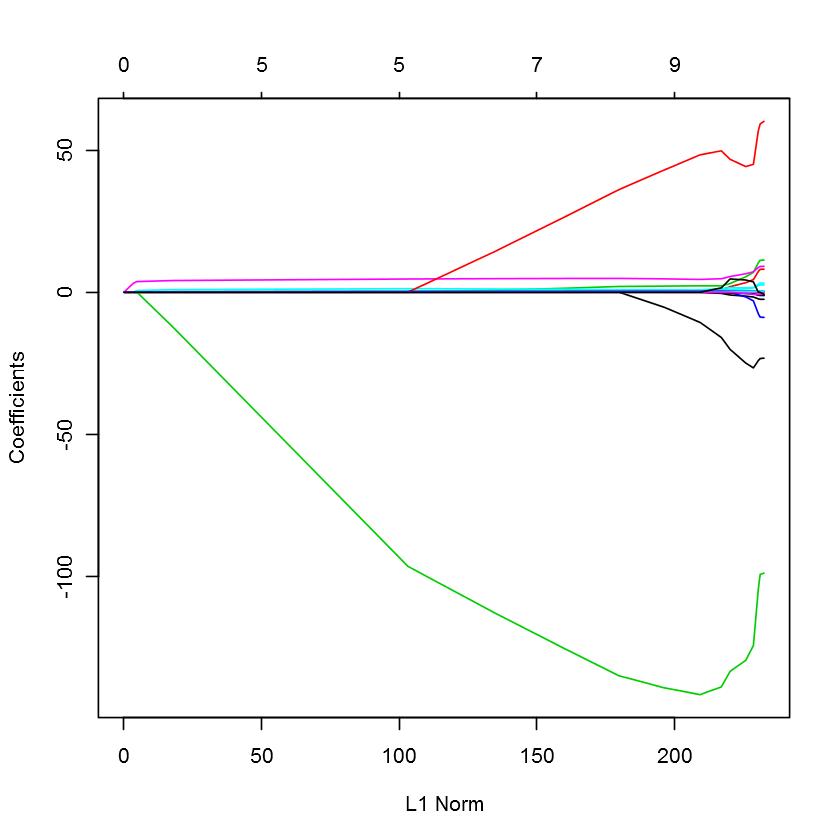

In [39]:
lasso.mod=glmnet(x[train,],y[train],alpha=1,lambda=grid)
plot(lasso.mod)
# We can see from the coefficient plot that depending on the choice of tuning
# parameter, some of the coefficients will be exactly equal to zero.

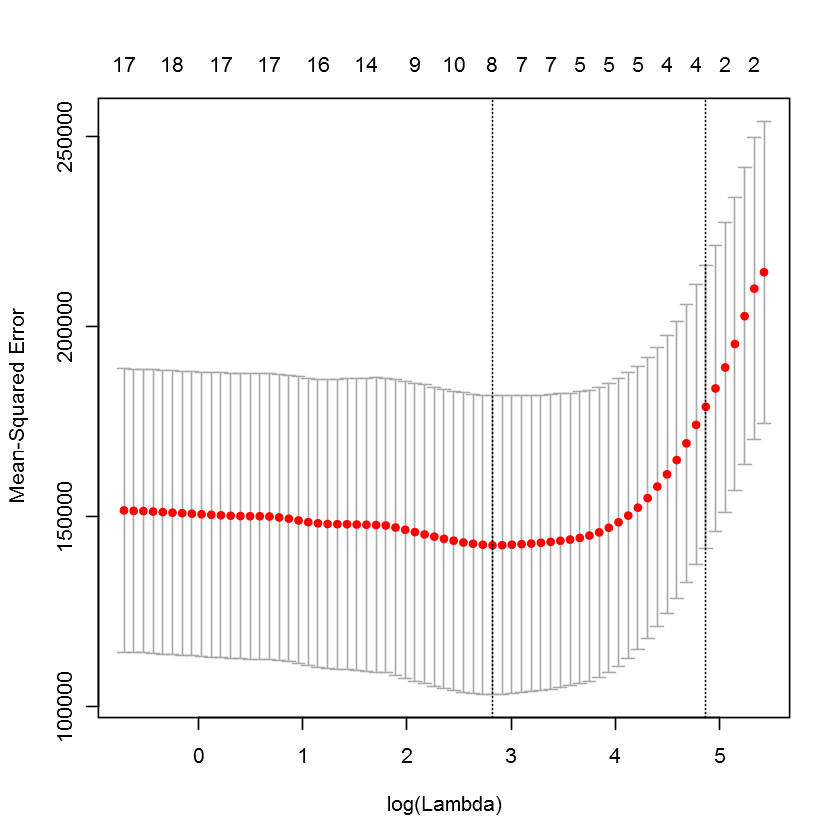

In [48]:
# Choose lambda with CV
set.seed(1)
cv.out=cv.glmnet(x[train,],y[train],alpha=1)
plot(cv.out)
bestlam=cv.out$lambda.min

In [53]:
# Compute the test MSE with best lambda
lasso.pred=predict(lasso.mod,s=bestlam,newx=x[test,])
mean((lasso.pred-y.test)^2)

out=glmnet(x,y,alpha=1,lambda=grid)
lasso.coef=predict(out,type="coefficients",s=bestlam)[1:20,]
lasso.coef
# Note that 12 coefficients are exactly 0!

[1] 100743.4

(Intercept)        AtBat         Hits        HmRun         Runs          RBI 
  18.5394844    0.0000000    1.8735390    0.0000000    0.0000000    0.0000000 
       Walks        Years       CAtBat        CHits       CHmRun        CRuns 
   2.2178444    0.0000000    0.0000000    0.0000000    0.0000000    0.2071252 
        CRBI       CWalks      LeagueN    DivisionW      PutOuts      Assists 
   0.4130132    0.0000000    3.2666677 -103.4845458    0.2204284    0.0000000 
      Errors   NewLeagueN 
   0.0000000    0.0000000

# Principal Components Regression

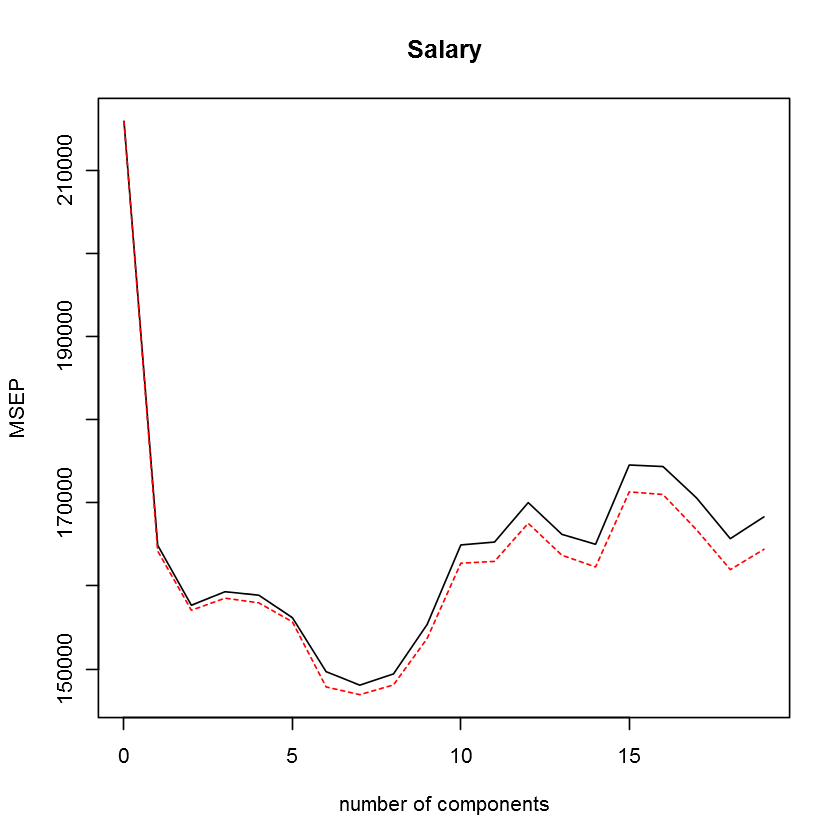

In [61]:
# Train the model
library(pls)
set.seed(1)
pcr.fit=pcr(Salary~., data=Hitters,subset=train,scale=TRUE, validation="CV")
validationplot(pcr.fit,val.type="MSEP")

In [65]:
# The best model was identified with ncomp = 7
pcr.fit=pcr(y~x,scale=TRUE,ncomp=7)
summary(pcr.fit)

# Test the model
pcr.pred=predict(pcr.fit,x[test,],ncomp=7)
mean((pcr.pred-y.test)^2)

Data: 	X dimension: 263 19 
	Y dimension: 263 1
Fit method: svdpc
Number of components considered: 7
TRAINING: % variance explained
   1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps
X    38.31    60.16    70.84    79.03    84.29    88.63    92.26
y    40.63    41.58    42.17    43.22    44.90    46.48    46.69


[1] 85199.48

# Partial Least Squares

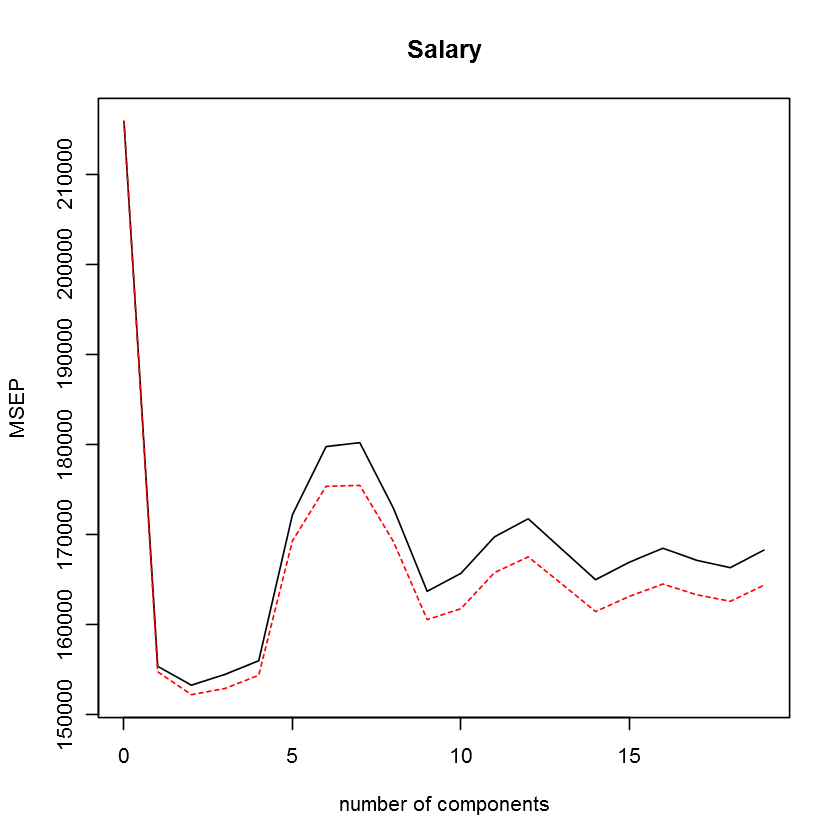

In [67]:
set.seed(1)
pls.fit=plsr(Salary~., data=Hitters,subset=train,scale=TRUE, validation="CV")
#summary(pls.fit)
validationplot(pls.fit,val.type="MSEP")

In [69]:
# The best model was identified with ncomp = 2
pls.fit=plsr(Salary~., data=Hitters,scale=TRUE,ncomp=2)
summary(pls.fit)

# Test the model
pls.pred=predict(pls.fit,x[test,],ncomp=2)
mean((pls.pred-y.test)^2)

Data: 	X dimension: 263 19 
	Y dimension: 263 1
Fit method: kernelpls
Number of components considered: 2
TRAINING: % variance explained
        1 comps  2 comps
X         38.08    51.03
Salary    43.05    46.40


[1] 84096.37

# Example: Model Selection with CV

12 
6.405823

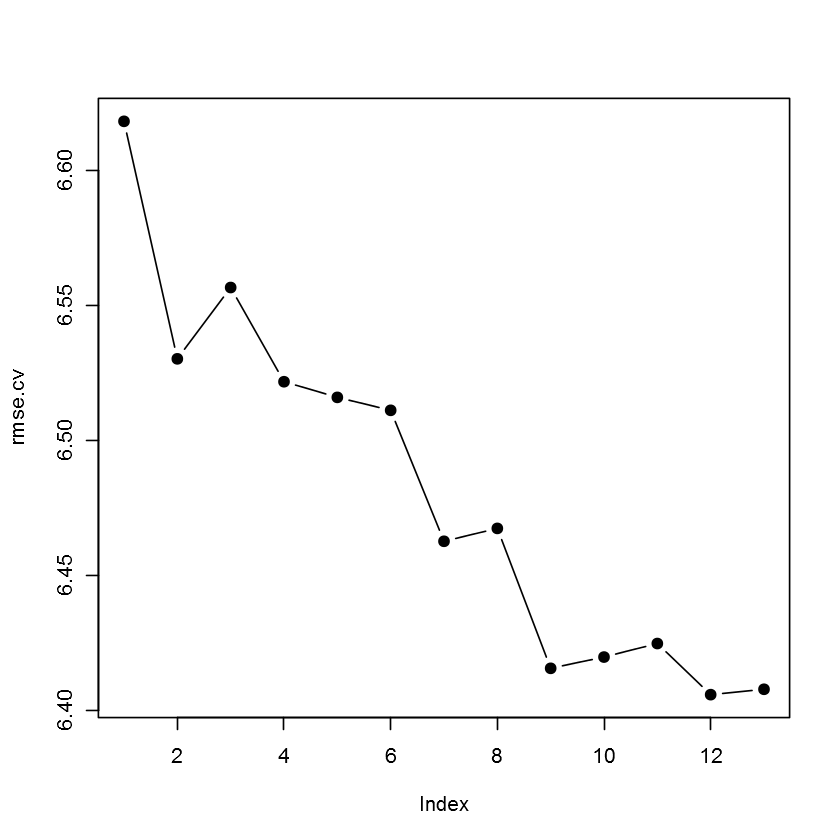

In [28]:
# Best subset selection
library(MASS)
set.seed(1)

predict.regsubsets <- function(object, newdata, id, ...) {
    form <- as.formula(object$call[[2]])
    mat <- model.matrix(form, newdata)
    coefi <- coef(object, id = id)
    xvars <- names(coefi)
    mat[, xvars] %*% coefi
}

k = 10
folds <- sample(1:k, nrow(Boston), replace = TRUE)
cv.errors <- matrix(NA, k, 13, dimnames = list(NULL, paste(1:13)))
for (j in 1:k) {
    best.fit <- regsubsets(crim ~ ., data = Boston[folds != j, ], nvmax = 13)
    for (i in 1:13) {
        pred <- predict(best.fit, Boston[folds == j, ], id = i)
        cv.errors[j, i] <- mean((Boston$crim[folds == j] - pred)^2)
    }
}
rmse.cv = sqrt(apply(cv.errors, 2, mean))
plot(rmse.cv, pch = 19, type = "b")

rmse.cv[which.min(rmse.cv)]

In [30]:
# Lasso
x = model.matrix(crim ~ . - 1, data = Boston)
y = Boston$crim
cv.lasso = cv.glmnet(x, y, type.measure = "mse")
#plot(cv.lasso)
coef(cv.lasso)
sqrt(cv.lasso$cvm[cv.lasso$lambda == cv.lasso$lambda.1se])

14 x 1 sparse Matrix of class "dgCMatrix"
                    1
(Intercept) 1.0894283
zn          .        
indus       .        
chas        .        
nox         .        
rm          .        
age         .        
dis         .        
rad         0.2643196
tax         .        
ptratio     .        
black       .        
lstat       .        
medv        .        

[1] 7.424338

In [31]:
# Ridge
x = model.matrix(crim ~ . - 1, data = Boston)
y = Boston$crim
cv.ridge = cv.glmnet(x, y, type.measure = "mse", alpha = 0)
#plot(cv.ridge)
coef(cv.ridge)
sqrt(cv.ridge$cvm[cv.ridge$lambda == cv.ridge$lambda.1se])

14 x 1 sparse Matrix of class "dgCMatrix"
                       1
(Intercept)  1.400465353
zn          -0.002958004
indus        0.030629045
chas        -0.179936010
nox          1.970152370
rm          -0.148397786
age          0.006502245
dis         -0.099606703
rad          0.049161233
tax          0.002222499
ptratio      0.075064827
black       -0.002779273
lstat        0.037863265
medv        -0.024852582

[1] 7.605814

In [34]:
# PCR
library(pls)
pcr.fit = pcr(crim ~ ., data = Boston, scale = TRUE, validation = "CV")
summary(pcr.fit)
# 13 component pcr fit has lowest CV/adjCV RMSEP.

Data: 	X dimension: 506 13 
	Y dimension: 506 1
Fit method: svdpc
Number of components considered: 13

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV            8.61    7.214    7.214    6.786    6.767    6.782    6.797
adjCV         8.61    7.211    7.211    6.779    6.759    6.776    6.790
       7 comps  8 comps  9 comps  10 comps  11 comps  12 comps  13 comps
CV       6.790    6.662    6.684     6.689     6.675     6.640     6.567
adjCV    6.783    6.654    6.676     6.680     6.665     6.629     6.556

TRAINING: % variance explained
      1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps  8 comps
X       47.70    60.36    69.67    76.45    82.99    88.00    91.14    93.45
crim    30.69    30.87    39.27    39.61    39.61    39.86    40.14    42.47
      9 comps  10 comps  11 comps  12 comps  13 comps
X       95.40     97.04     98.46     99.52     100.0
crim    42.55     42.78     